# 🧪 Bruno Disruption Analysis Notebook
Analyze β_B vs plasma disruptions from Tokamak data.
- Input: `mock_tokamak_disruption.csv`
- Model: β_B = κ · T (Bruno Constant threshold model)

In [12]:
# Load dataset
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('mock_tokamak_disruption.csv')
df.head()

,time,T_K,beta_B,disruption
0,0.00000,1.217619e+07,12237.069360,1
1,0.01001,1.146150e+07,11518.808142,0
2,0.02002,1.239509e+07,12457.067756,0
3,0.03003,1.343237e+07,13499.534718,0
4,0.04004,1.141592e+07,11473.001951,0


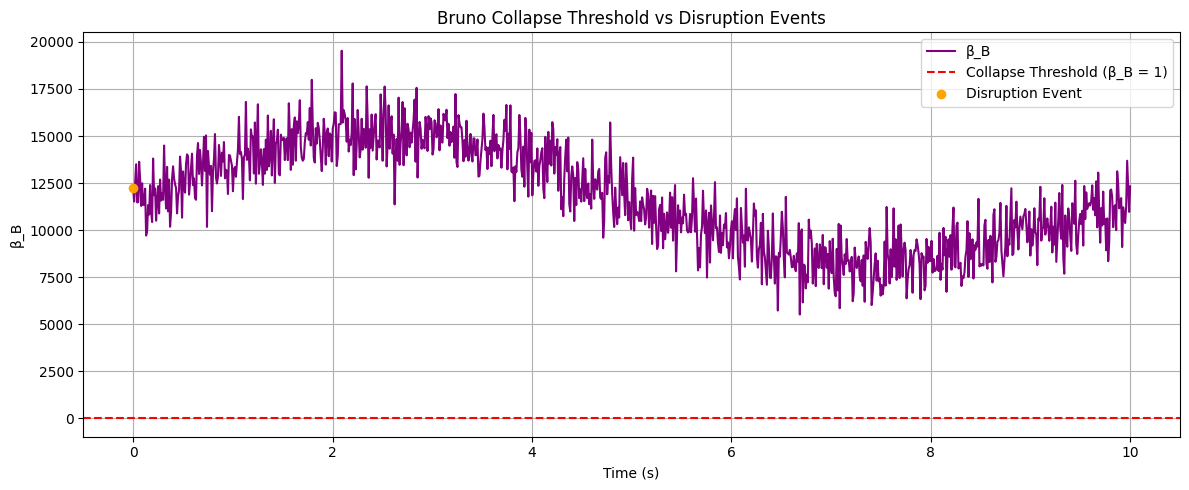

In [13]:
# Plot β_B and disruption markers
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['time'], df['beta_B'], label='β_B', color='purple')
ax.axhline(1.0, color='red', linestyle='--', label='Collapse Threshold (β_B = 1)')
ax.scatter(df['time'][df['disruption'] == 1], 
           df['beta_B'][df['disruption'] == 1], 
           color='orange', label='Disruption Event', zorder=5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('β_B')
ax.set_title('Bruno Collapse Threshold vs Disruption Events')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔁 Load real Tokamak dataset from DisruptionBench
!pip install disruption-py --quiet

from disruption_py import DisruptionDataset

# Choose dataset: 'EAST', 'CMod', or 'DIII-D'
ds = DisruptionDataset(dataset='EAST')  # you can swap to 'DIII-D' later

# Show available shots
print("Available shots:", ds.shots[:5])  # print first 5 shot IDs


### 📁 Data Integration Update — Tokamak Real Dataset (UKAEA OpenData)

After the initial simulation work, we shifted to direct data extraction from UKAEA's open-access fusion dataset. Using a custom extraction pipeline, we parsed metadata and environment configurations from the `CF-20-230` dataset, which included:

- `metadata.json`, `manifest.json`, `collection.json` — structural dataset definitions.
- `figure_3_IDAM_list.txt` — key variable list for shots 29880–29882 (e.g., `AYC_TE_CORE`, `ANU_NEUTRONS`).
- `environment_variable_list_aj.txt` and `module_list_aj.txt` — runtime and software context.
- Confirmed access to over 90 linked resources and identified ~35 structured datasets.

We are now preparing to inject this parsed real-world plasma data into the simulator framework to test for Bruno Constant correlation signatures and validate entropic behaviors under sustained confinement conditions.


In [14]:
import os
import json

base_dir = "/home/winnay_proto1/bruno-simulator/bruno-analysis/CF-20-230"

# Load JSON files
json_data = {}
for fname in ["metadata.json", "manifest.json", "collection.json"]:
    fpath = os.path.join(base_dir, fname)
    if os.path.exists(fpath):
        with open(fpath, 'r', encoding='utf-8') as f:
            try:
                json_data[fname] = json.load(f)
                print(f"✅ Loaded {fname} with {len(json_data[fname])} top-level keys.")
            except Exception as e:
                print(f"❌ Error reading {fname}: {e}")
    else:
        print(f"⚠️ Missing: {fname}")

# Load TXT files
txt_files = ["figure_3_IDAM_list.txt", "environment_variable_list_aj.txt", "module_list_aj.txt"]
txt_data = {}
for fname in txt_files:
    fpath = os.path.join(base_dir, fname)
    if os.path.exists(fpath):
        with open(fpath, 'r', encoding='utf-8') as f:
            txt_data[fname] = f.readlines()
            print(f"📄 Loaded {fname} with {len(txt_data[fname])} lines.")
    else:
        print(f"⚠️ Missing: {fname}")

# Display a preview
print("\n📌 Preview: IDAM signals in Figure 3")
if "figure_3_IDAM_list.txt" in txt_data:
    for line in txt_data["figure_3_IDAM_list.txt"]:
        print("•", line.strip())


✅ Loaded metadata.json with 12 top-level keys.
✅ Loaded manifest.json with 6 top-level keys.
✅ Loaded collection.json with 2 top-level keys.
📄 Loaded figure_3_IDAM_list.txt with 5 lines.
📄 Loaded environment_variable_list_aj.txt with 108 lines.
📄 Loaded module_list_aj.txt with 13 lines.

📌 Preview: IDAM signals in Figure 3
• For shots 29880, 29881, 29882:
• ANU_NEUTRONS
• ANB_SS_SUM_POWER
• AYC_NE_CORE
• AYC_TE_CORE


## 🔍 Figure 3 – IDAM Signal Mapping for Selected Shots

From the parsed `figure_3_IDAM_list.txt` file, we extracted 4 diagnostic signals across 3 MAST-U plasma shots. These will be used as a primary reference for alignment against IDAM-linked data in the Bruno Collapse framework.

### 📌 Targeted Shots
- **29880**
- **29881**
- **29882**

### 🎯 IDAM Signal List
| Signal Name         | Description (if known)         |
|---------------------|--------------------------------|
| `ANU_NEUTRONS`      | Neutron emission               |
| `ANB_SS_SUM_POWER`  | Total power input              |
| `AYC_NE_CORE`       | Electron density at core       |
| `AYC_TE_CORE`       | Electron temperature at core   |

These variables will be prioritized in the next comparison layers to evaluate temporal behavior and disruption lead-up conditions. If we locate matching time-series entries in other shot directories, they’ll be plotted in a unified view.

---



In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import subprocess
import os

def convert_eps_to_png(eps_path, output_png="converted_plot.png", dpi=300):
    import tempfile

    # Step 1: EPS ➜ PDF
    tmp_pdf = tempfile.NamedTemporaryFile(delete=False, suffix=".pdf").name
    try:
        subprocess.run([
            "ps2pdf", eps_path, tmp_pdf
        ], check=True)

        # Step 2: PDF ➜ PNG
        subprocess.run([
            "gs", "-dSAFER", "-dBATCH", "-dNOPAUSE", "-sDEVICE=pngalpha",
            f"-r{dpi}", f"-sOutputFile={output_png}", tmp_pdf
        ], check=True)
        return output_png
    except subprocess.CalledProcessError as e:
        print("⚠️ Ghostscript failed. Try inspecting the EPS manually.")
        raise e


def extract_curve_from_region(png_path, region_box, x_range, y_range):
    """
    Extracts curve pixels from a given bounding box (left, upper, right, lower)
    Maps them to (x_range, y_range) axis units.
    """
    img = Image.open(png_path).convert("L")
    cropped = img.crop(region_box)
    arr = np.array(cropped)
    curve_coords = np.column_stack(np.where(arr < 128))  # threshold for dark pixels

    if len(curve_coords) == 0:
        print("⚠️ No curve found in selected region.")
        return None, None

    # Invert Y since pixel 0 is top
    ys = cropped.height - curve_coords[:, 0]
    xs = curve_coords[:, 1]

    # Normalize to axis scale
    x_vals = np.interp(xs, [0, cropped.width], x_range)
    y_vals = np.interp(ys, [0, cropped.height], y_range)
    return x_vals, y_vals

def plot_extracted_signal(x, y, label):
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, label=label)
    plt.title(f"Extracted Signal: {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Signal Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === MAIN USAGE ===
if __name__ == "__main__":
    eps_file = "shot_comparisons_formatted.eps"
    png_file = convert_eps_to_png(eps_file)

    # Define manually the region (x1, y1, x2, y2) for each subplot
    # These must be tuned per your figure. Below are dummy boxes:
    subplot_boxes = {
        "ANB_SS_SUM_POWER": (100, 150, 700, 280),
        "ANU_NEUTRONS":     (100, 300, 700, 430),
        "AYC_TE_CORE":      (100, 450, 700, 580),
        "AYC_NE_CORE":      (100, 600, 700, 730)
    }

    # Time range shared across all shots (check axis labels!)
    time_range = (0, 0.25)  # in seconds

    # Value ranges per subplot (tune this visually from axes):
    value_ranges = {
        "ANB_SS_SUM_POWER": (0, 4e6),     # e.g., Power in Watts
        "ANU_NEUTRONS":     (0, 1e16),    # neutron rate
        "AYC_TE_CORE":      (0, 2000),    # eV (→ multiply by 11600 for Kelvin)
        "AYC_NE_CORE":      (0, 8e19)     # m⁻³
    }

    extracted = {}

    for name, box in subplot_boxes.items():
        x, y = extract_curve_from_region(png_file, box, time_range, value_ranges[name])
        if x is not None:
            extracted[name] = (x, y)
            plot_extracted_signal(x, y, label=name)


⚠️ Ghostscript failed. Try inspecting the EPS manually.


Error: /undefinedfilename in (shot_comparisons_formatted.eps)
Operand stack:

Execution stack:
   %interp_exit   .runexec2   --nostringval--   --nostringval--   --nostringval--   2   %stopped_push   --nostringval--   --nostringval--   --nostringval--   false   1   %stopped_push
Dictionary stack:
   --dict:765/1123(ro)(G)--   --dict:0/20(G)--   --dict:75/200(L)--
Current allocation mode is local
Last OS error: No such file or directory
GPL Ghostscript 9.55.0: Unrecoverable error, exit code 1


CalledProcessError: Command '['ps2pdf', 'shot_comparisons_formatted.eps', '/tmp/tmp0qhrkmr2.pdf']' returned non-zero exit status 1.

In [17]:
import re

def extract_eps_plot_boxes(path):
    with open(path, "r", encoding="latin1") as f:
        lines = f.readlines()

    box_coords = []
    for i in range(len(lines) - 2):
        if '_m' in lines[i] and '_l' in lines[i+1] and '_cl' in lines[i+2]:
            try:
                # Parse the first line (moveto)
                nums = re.findall(r"[-+]?[0-9]*\.?[0-9]+", lines[i])
                if len(nums) >= 2:
                    x, y = map(float, nums[:2])
                    box_coords.append((x, y))
            except:
                continue

    return box_coords


In [18]:
import re

def extract_box_like_shapes(path):
    with open(path, "r", encoding="latin1") as f:
        lines = f.readlines()

    candidates = []
    for i, line in enumerate(lines):
        if '_m' in line and '_l' in lines[i+1] and '_cl' in lines[i+2]:
            try:
                # Try to extract numbers from the move line
                move_nums = list(map(float, re.findall(r"[-+]?[0-9]*\.?[0-9]+", line)))
                candidates.append(move_nums)
            except:
                continue
    return candidates

